In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Okt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer 
from wordcloud import WordCloud

In [2]:
def get_data_sent_dict(product_name='', count=0):
  """
  product_name : 검색키워드(제품명)
  count : 분석 실행 횟수 -> 추후 함수끼리 연결하면서 변경 필요 
  """
  
  path = '../data/제품/shin_naver_500.csv'
  total_review = pd.read_csv(path)
  #total_review = total_review[:8000] # 추후 삭제 필요 **********************

  #print(total_review.info())
  sample_data=total_review['review']

  return sample_data, total_review

In [3]:
sample_data, total_review=get_data_sent_dict()

In [6]:
# 감성사전 가져오기
import json
with open('../data/SentiWord_info.json', encoding='utf-8-sig', mode='r') as f:
    data = json.load(f)

### 1. 토큰화 함수

In [8]:
def tokenize(sample_data):
    okt=Okt()

    sample_data_normalize=sample_data.apply(okt.normalize)
    
    tokenized_sent=[]
    for i in range(len(sample_data)):
        tokenized_sent.append(okt.morphs(sample_data_normalize[i], stem=True)) 
        
    return tokenized_sent    

In [9]:
tokenized_sent=tokenize(sample_data)

### 긍부정 점수계산 함수화

In [10]:
def sent_analyz(tokenized_sent):
    result = []
    for i in range(len(data)):
        for k in range(len(tokenized_sent)):
            if data[i]['word']==tokenized_sent[k]:
                result.append(data[i]['word_root'])
                result.append(data[i]['polarity'])	
                
    #점수계산     
    a=result[1::2]
    change_int=list(map(int, a))   


    try:
        score=(sum(change_int)/len(a))+3
    except:
        score=0
    #print(score)

    return score

### 입력받은 n개 데이터를 전처리부터 긍부정예측까지 하는 함수

In [11]:
# 입력받은 리뷰 데이터들 토큰화해서 점수계산
def all_process_analyze(want_analyze_col):
    token_sent=tokenize(want_analyze_col)
    
    sent_score_list=[]
    for i in range(len(token_sent)):
        sent_score_list.append(sent_analyz(token_sent[i]))
    total_score = round(sum(sent_score_list)/len(sent_score_list), 2)
    return total_score, sent_score_list

In [12]:
total_score, sent_score_list = all_process_analyze(sample_data)

In [13]:
total_review['score']=sent_score_list

In [14]:
# 감성사전 통과한 review들의 점수를 'score'컬럼에 추가
total_review

,type,review,star,date,site,score
0,농심 신라면,제 2의 주식. 쌀과 같은 존재.,5,221118,롯데마트,0.000000
1,농심 신라면,라면 왜이리 오르는지요....농심을 떠날때가 되었나...,5,221117,SSG닷컴,0.000000
2,농심 신라면,면발이 쫀득하고 국물이 얼큰해요 다아는맛 맛있어요,5,221117,롯데마트,5.000000
3,농심 신라면,좋아하지는 않는데 가끔 생각나서 구매했습니다,4,221117,롯데마트,5.000000
4,농심 신라면,자주 먹진 않아도 비상식품으로 갖춰둡니다.,5,221117,롯데마트,4.000000
...,...,...,...,...,...,...
3775,농심 신라면,언제나 쟁여두고 먹는 신라면!,5,221105,롯데ON,0.000000
3776,농심 신라면,좋아요마니파세요잘먹알께요,5,221105,Homeplus,5.000000
3777,농심 신라면,신라면은 언제나 맛있습니다,5,221105,11번가,5.000000
3778,농심 신라면,포장꼼꼼하고 맛있고 좋아여.,5,221105,GSSHOP,4.666667


In [ ]:
'../data/시각화/shin_0_ratio.png'
'../data/시각화/shin_neg_0_cloud.png'
'../data/시각화/shin_pos_0_cloud.png'
'../data/시각화/purmil_pos_0_cloud.png'
'../data/시각화/jin_0_ratio.png'

### 긍부정 문장 비율 계산

In [27]:
# 긍부정 문장비율 파이차트 반환
def pos_neg_ratio():
    pos_sent=[]
    neg_sent=[]

    for score in sent_score_list:
        if score > 3.3:
            pos_sent.append(score)
        elif score < 2.7:
            neg_sent.append(score)    

    ratio = [len(pos_sent)/len(sent_score_list), len(neg_sent)/len(sent_score_list)]
    labels = ['Postive', 'Negative']
    explode = [0, 0.10]
    colors = ['skyblue', 'tomato']
    plt.title('Pos, Neg Review Ratio')
    plt.pie(ratio, explode = explode,colors=colors, labels=labels, autopct='%.1f%%', startangle=90)
    plt.show()


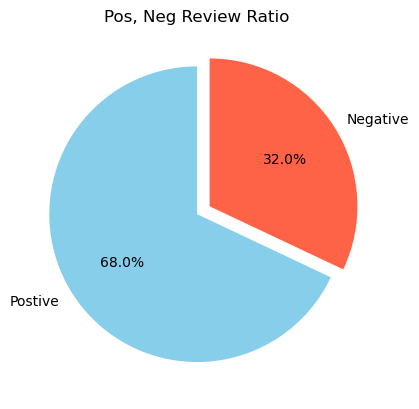

In [28]:
pos_neg_ratio()

### 많이쓰인 긍부정 단어 워드 클라우드

In [17]:
# 한문장 감성사전 통과하고 긍부정 단어 나눠서 담기 함수

def word_key_cloud(tokenized_sent):

    pos_word=[]
    neg_word=[]
    for i in range(len(data)):
        for k in range(len(tokenized_sent)):
            if data[i]['word']==tokenized_sent[k]:
                if data[i]['polarity'] in ('1', '2'):
                    pos_word.append(data[i]['word_root'])
                elif data[i]['polarity'] in ('-1', '-2'):
                    neg_word.append(data[i]['word_root'])   
                
    

    return pos_word, neg_word

In [18]:
def seprate_pos_neg():
    # n개문장 word_key_cloud 함수 적용하기
    word_list=[]
    for i in range(len(tokenized_sent)):
        word_list.append(word_key_cloud(tokenized_sent[i]))

    # 감성사전 통과한 단어들 리스트2개에서 빼내서 긍부정 리스트에 각각 담기
    pos_word=[]
    neg_word=[]

    for list in word_list:
        pos_word.append(list[0])
        neg_word.append(list[1])

    # 긍정)) 감성사전 통과한 단어들 리스트2개에서 빼내서 담기
    pos_filterd_word=[]
    for pos_one_word in pos_word:
        for word in pos_one_word:
            pos_filterd_word.append(word)
    

    # 부정)) 감성사전 통과한 단어들 리스트2개에서 빼내서 담기
    neg_filterd_word=[]
    for neg_one_word in neg_word:
        for word in neg_one_word:
            neg_filterd_word.append(word)
    

    return pos_filterd_word, neg_filterd_word


In [19]:
pos_filterd_word, neg_filterd_word=seprate_pos_neg()

In [61]:
def make_cloud(filterd_word):
    pos_or_neg_num = Counter(filterd_word)
    # 긍정 워드클라우드
    wc = WordCloud(font_path='malgun', width=1000, height=800, scale=2.0, background_color='white', colormap='ocean').generate_from_frequencies(pos_or_neg_num)
    plt.figure(frameon=False)
    plt.axis('off')
    return plt.imshow(wc)
    

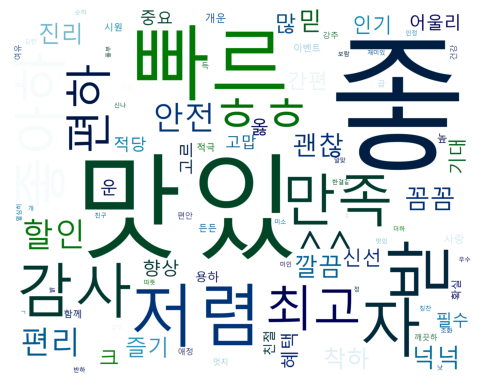

In [62]:
make_cloud(pos_filterd_word)

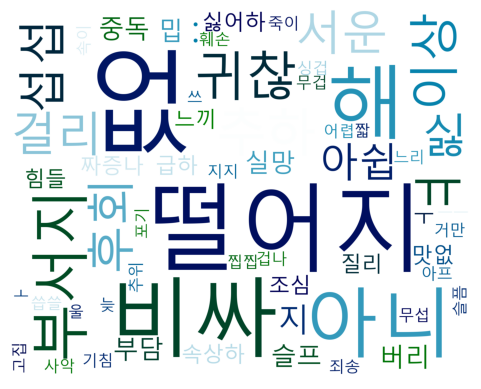

In [63]:
make_cloud(neg_filterd_word)